In [1]:
from rouge_score.rouge_scorer import _create_ngrams
from nltk.stem.porter import PorterStemmer
import json
import six
from utils import tokenize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import os
from tqdm import tqdm
import openai
import time 

start_time = time.time()

METHOD = "DNAGPT"
DATA = "ELI5"
PATH = "./regenerated/results_eli5.json"

# Prepare OpenAI parameters
openai.api_key = "API_KEY"
os.environ['AZURE_OPENAI_ENDPOINT'] = "API_ENDPOINT"
openai.api_type = "azure"
openai.api_version = "API_DATE"

#! N-Gram Score Generation
def get_score_ngrams(target_ngrams, prediction_ngrams):
    intersection_ngrams_count = 0
    ngram_dict = {}
    for ngram in six.iterkeys(target_ngrams):
        intersection_ngrams_count += min(target_ngrams[ngram],
                                        prediction_ngrams[ngram])
        ngram_dict[ngram] = min(target_ngrams[ngram], prediction_ngrams[ngram])
    target_ngrams_count = sum(target_ngrams.values()) # prediction_ngrams
    return intersection_ngrams_count / max(target_ngrams_count, 1), ngram_dict


def get_ngram_info(article_tokens, summary_tokens, _ngram):
    article_ngram = _create_ngrams( article_tokens , _ngram)
    summary_ngram = _create_ngrams( summary_tokens , _ngram)
    ngram_score, ngram_dict = get_score_ngrams( article_ngram, summary_ngram) 
    return ngram_score, ngram_dict, sum( ngram_dict.values() )

print("Loading Data...")
#! Load Data from file
data = None
with open(PATH, "r") as f:
    data = json.load(f)
print(f"{len(data)} generated texts loaded.")

Loading Data...
2986 generated texts loaded.


In [2]:
#! Calculate n-grams
ngram_overlap_count_wq = []
for idx in tqdm(range(len(data))):
    # tokenization
    cur = data[idx]
    masked_original = cur["masked_original"]
    human_tokenized = tokenize(masked_original, stemmer=PorterStemmer())
    generated = cur["masked_generated"]
    if generated == None: continue

    # going through each generation
    temp = []
    for j in range(len(generated)):
        tempp = {} # storing all the ngram scores
        generated_tokenized = tokenize(generated[j], stemmer=PorterStemmer())
        if len(human_tokenized) == 0 or len(generated_tokenized) == 0:
            continue
        
        # go through each possible n gram from 1 to 25
        for _ngram in range(1, 25):
            ngram_score, ngram_dict, overlap_count = get_ngram_info(human_tokenized, generated_tokenized, _ngram)
            if cur["type"] == "human":
                tempp['human_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(generated_tokenized)
            else:
                tempp['gpt_truncate_ngram_{}_score'.format(_ngram)] = ngram_score / len(generated_tokenized)
        temp.append({'type':cur["type"], 'ngrams': tempp})

    ngram_overlap_count_wq.append(temp)

100%|██████████| 2986/2986 [21:58<00:00,  2.26it/s]


In [3]:
#! N Gram Detector
def n_gram_detector(ngram_n_ratio):
    score = 0
    non_zero = []
    
    for idx, key in enumerate(ngram_n_ratio):
        # if idx in range(2) and 'score' in key or 'ratio' in key:
        #     score += 0.0 * ngram_n_ratio[ key ]
        #     continue
        if 'score' in key or 'ratio' in key:
            score += (idx+1) * np.log((idx+1)) * ngram_n_ratio[ key ]
            if ngram_n_ratio[ key ] != 0:
                non_zero.append( idx+1 )
    return score/ (sum( non_zero ) + 1e-8)

human_scores = []
ai_scores= []

for idx in tqdm(range(len(ngram_overlap_count_wq))):
    human_score = []
    ai_score = []

    for i in ngram_overlap_count_wq[idx]:
        if i["type"] == "human":
            human_score.append(n_gram_detector(i["ngrams"]))
        else:
            ai_score.append(n_gram_detector(i["ngrams"]))
    
    if len(human_score) != 0:
        human_scores.append(min(human_score))
    elif len(ai_score) != 0:
        ai_scores.append(min(ai_score))

100%|██████████| 2964/2964 [00:02<00:00, 1352.71it/s]


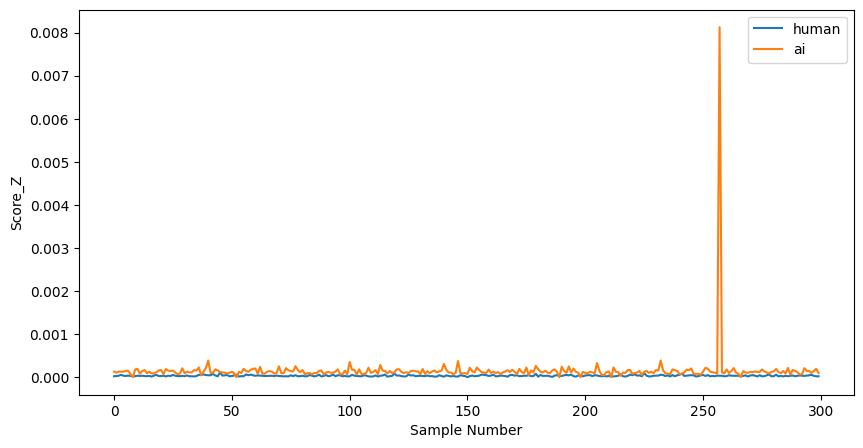

In [7]:
human_scores = human_scores[:300]
ai_scores = ai_scores[:300]

#! Plot Results
plt.figure(figsize=(10, 5))
plt.ylabel("Score_Z")
plt.xlabel("Sample Number")
plt.plot(human_scores, label='human')
plt.plot(ai_scores, label='ai')
plt.legend()
plt.show()

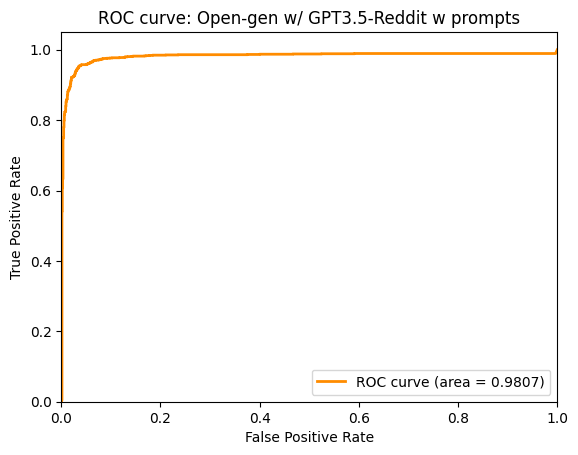

TPR at 1% FPR: 0.5908009587096994


In [5]:
#! ROC Curve Plotting
def plot_roc_curve(human_scores, gpt_scores):
    # Data
    A = human_scores
    B = gpt_scores
    # Combine scores and true labels
    scores = A + B
    labels = [0] * len(A) + [1] * len(B)
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    # Calculate AUC (Area Under Curve)
    roc_auc = auc(fpr, tpr)
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve: Open-gen w/ GPT3.5-Reddit w prompts' )
    plt.legend(loc="lower right")
    plt.show()

    # find the closest fpr more than 1% fpr
    coords1 = (0, 0)
    for idx, fpr_ in enumerate(fpr):
        if fpr_ > 0.01:
            coords1 = (float(fpr[idx]), float(tpr[idx]))
            break
    
    coords2 = (0, 0)
    for idx, fpr_ in enumerate(reversed(fpr)):
        if fpr_ < 0.01:
            coords2 = (float(fpr[len(fpr) - idx - 1]), float(fpr[len(fpr) - idx - 1]))
            break

    # (x1, y1) and (x2, y2)
    # Gradient = (y2 - y1) / (x2 - x1)
    # y = [(y2 - y1) / (x2 - x1)] (0.01 - x2) + y2
    tpr_at_one_fpr = ((coords2[1] - coords1[1]) / (coords2[0] - coords1[0])) * (0.01 - coords2[0]) + coords2[1]
    print(f"TPR at 1% FPR: {tpr_at_one_fpr}")

plot_roc_curve(human_scores, ai_scores)

In [6]:
# Save Results
import json

if not os.path.exists(f"./results/{DATA}"):
    os.makedirs(f"./results/{DATA}")

with open(f"./results/{DATA}/{METHOD}.json", "w+") as f:
	json.dump({"ai_scores": ai_scores, "human_scores": human_scores, "time": time.time() - start_time}, f)